# Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import joblib
import json
import tensorflow as tf



# Load Saved Models

In [3]:
# Load the models and scalers
xgb_model = joblib.load('xgboost_model.joblib')
lstm_model = tf.keras.models.load_model('lstm_model.keras')
feature_scaler = joblib.load('feature_scaler.joblib')
target_scaler = joblib.load('target_scaler.joblib')

# Load sequence length from config
with open('config.json', 'r') as f:
    config = json.load(f)
    sequence_length = config['sequence_length']

c:\Users\timoz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


# Data Preprocessing

In [4]:
# Load the data
data = pd.read_csv('../datasets/nvda.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()


# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)


# Remove Na values
data.dropna(inplace=True)
data.head(500)

         Date   Open     High    Low  Close    Volume
0  2010-01-04  18.51  18.6200  18.11  18.49  20005100
1  2010-01-05  18.51  18.9600  18.42  18.76  18216200
2  2010-01-06  18.75  18.9200  18.57  18.88  16229200
3  2010-01-07  18.78  18.8600  18.37  18.51  13694800
4  2010-01-08  18.36  18.6821  18.25  18.55  11954200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2010-03-16,17.15,17.86,17.14,17.755,16624700,17.389,17.1875,16.93125,17.0574,17.393401,17.228277,17.063097,17.180483,65.751634
50,2010-03-17,17.86,18.34,17.86,18.100,16279200,17.491,17.3345,16.94425,17.0496,17.628934,17.386772,17.161850,17.216543,71.144279
51,2010-03-18,18.13,18.13,17.30,17.460,18524100,17.545,17.4145,16.98375,17.0236,17.572623,17.400087,17.190245,17.226090,64.125561
52,2010-03-19,17.72,17.77,17.03,17.250,14615300,17.545,17.4225,17.01725,16.9910,17.465082,17.372798,17.195936,17.227028,54.975124
53,2010-03-22,17.03,17.60,17.03,17.530,10883400,17.619,17.4835,17.06325,16.9714,17.486721,17.401380,17.227752,17.238909,58.041958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2012-03-01,15.21,15.43,15.15,15.250,11248600,15.398,15.6945,15.83750,14.8944,15.388932,15.560213,15.553745,15.181346,31.448763
545,2012-03-02,15.20,15.60,15.20,15.380,17101900,15.316,15.5875,15.83225,14.9389,15.385954,15.527447,15.537198,15.189136,39.921722
546,2012-03-05,15.27,15.30,14.75,14.860,12871200,15.194,15.4885,15.78425,14.9581,15.210636,15.406093,15.472703,15.176229,27.127660
547,2012-03-06,14.69,14.81,14.46,14.720,11785000,15.072,15.3680,15.73550,14.9781,15.047091,15.281349,15.401017,15.158337,23.519164


In [5]:
from xgboost import XGBRegressor


feature_columns = [
    'Close',          
    'Low',            
    'High',           
    'Open',           
    'EMA for 5 days', 
    'MA for 5 days',  
    'RSI_14'          
]

X = data[feature_columns].values
y = data['Close'].values

# Scale features using the loaded scaler
X_scaled = feature_scaler.transform(X)

# Get XGBoost predictions
xgb_predictions = xgb_model.predict(X_scaled)

# Combine features with XGBoost predictions
combined_features = np.column_stack((X_scaled, xgb_predictions))

# Create sequences for LSTM
X_sequences = []
y_actual = []

for i in range(len(combined_features) - sequence_length):
    X_sequences.append(combined_features[i:(i + sequence_length)])
    y_actual.append(y[i + sequence_length])

X_sequences = np.array(X_sequences)
y_actual = np.array(y_actual)

In [6]:
# Make predictions
lstm_predictions = lstm_model.predict(X_sequences)
final_predictions = target_scaler.inverse_transform(lstm_predictions)


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


# Performance Evaluation

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


# Get actual values
actual_values = y[sequence_length:]

# Calculate the split point for the last 20% of the data
split_idx = int(len(actual_values) * 0.8)

# Get only the validation portion (last 20%)
val_actual = actual_values[split_idx:]
val_predictions = final_predictions[split_idx:]

# Calculate metrics on validation set only
mse = mean_squared_error(val_actual, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actual, val_predictions)
r2 = r2_score(val_actual, val_predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE:{rmse:.2f} ")
print(f"MAE: {mae:.2f} ")
print(f"R2 Score: {r2:.4f} ")



Performance Metrics:
MSE: 2267.97
RMSE:47.62 
MAE: 32.96 
R2 Score: 0.8814 


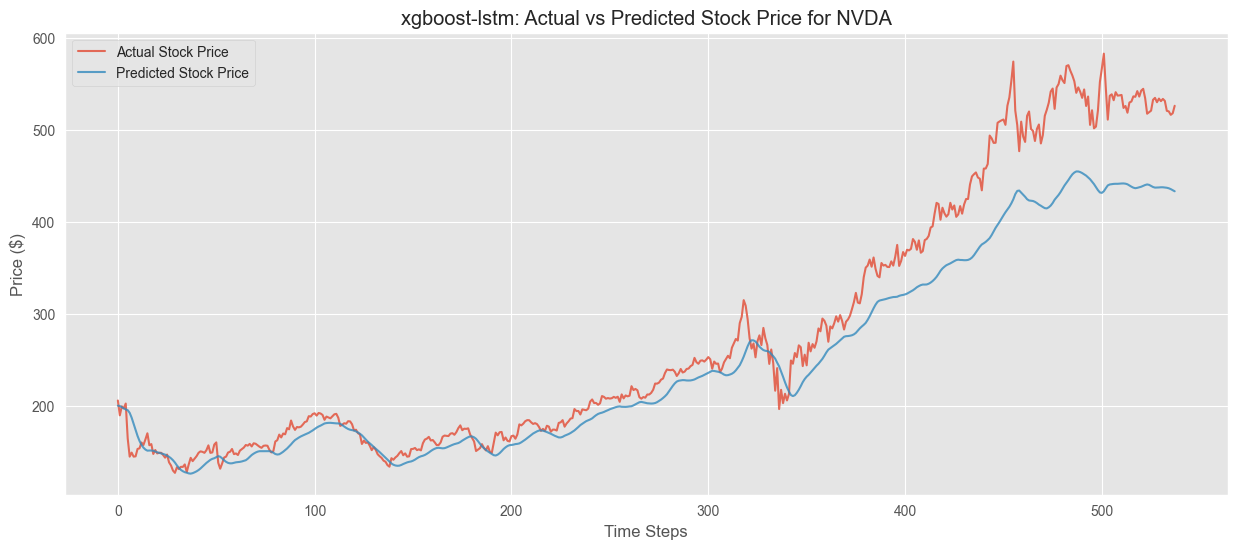

In [8]:
# Plot results
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Stock Price', alpha=0.8)
plt.plot(val_predictions, label='Predicted Stock Price', alpha=0.8)
plt.title('xgboost-lstm: Actual vs Predicted Stock Price for NVDA')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
def save_metrics(test_label, predicted, model_name, stock_name):
    """
    Calculate metrics and save to CSV 
    """
    # Calculate metrics
    mse = mean_squared_error(test_label, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_label, predicted)
    mape = np.mean(np.abs((test_label - predicted) / test_label)) * 100
    r2 = r2_score(test_label, predicted)
    
    # Round to 4 decimal places
    rmse = round(rmse, 4)
    mae = round(mae, 4)
    mape = round(mape, 4)
    r2 = round(r2, 4)
    mse = round(mse, 4)
    
    # Create metrics dictionary
    metrics = {
        'Model': [model_name],
        'Stock': [stock_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'R2': [r2]
    }
    
    # Convert to DataFrame
    df_metrics = pd.DataFrame(metrics)
    
    # Save to CSV
    filename = f'metrics_{model_name}_{stock_name}.csv'
    df_metrics.to_csv(filename, index=False)
    
    # Print metrics
    print(f"\nMetrics for {model_name} on {stock_name}:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")
    print(f"R² Score: {r2:.4f}")

In [10]:
# Save metrics to CSV
save_metrics(val_actual, val_predictions, 'XGBoost-LSTM', 'NVDA')


Metrics for XGBoost-LSTM on NVDA:
Mean Squared Error (MSE): 2267.9697
Root Mean Squared Error (RMSE): 47.6232
Mean Absolute Error (MAE): 32.9601
Mean Absolute Percentage Error (MAPE): 50.1240%
R² Score: 0.8814
